In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# FENICSx imports
import ufl
import dolfinx
from mpi4py import MPI
from petsc4py.PETSc import ScalarType as dtype

sys.path.append('..')
%aimport mre_pinn

dtype

Using backend: pytorch



numpy.complex128

## 2D Helmholtz inverse FEM

We want to solve for the elasticity field $\mu: \Omega \to \mathbb{C}$ given the wave field $u: \Omega \to \mathbb{C}^2$, where $\Omega \subset \mathbb{R}^2$.

Strong form:

$$
\begin{align}
    \mu(\mathbf{x}) \nabla^2 u(\mathbf{x}) + \rho \omega^2 u(\mathbf{x}) &= 0
\end{align}
$$

In [118]:
%autoreload

# load the data set
data, _ = mre_pinn.data.load_bioqic_dataset(
    '../data/BIOQIC', 'fem_box', frequency=80, xyz_slice='2D', downsample=False
)
data

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    spatial_region  (x, y) int64 

<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    spatial_region  (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    Lu              (frequency, x, y, component) complex128 (-0.0057547091471...
    Mu              (frequency, x, y) complex128 (3768.976611513677-1443.9860...

<IPython.core.display.Javascript object>


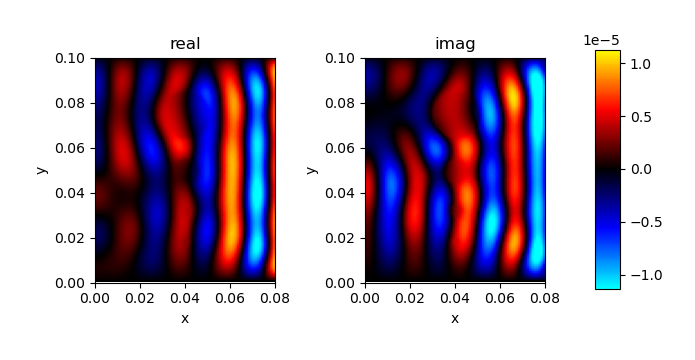

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [119]:
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
mre_pinn.visual.XArrayViewer(data.u, col='part', ax_width=2, **wave_kws)
#mre_pinn.visual.XArrayViewer(data.Lu, col='part', ax_width=2, **laplace_kws)

In [121]:
# get the domain from the wave field data

n_frequency, n_x, n_y, n_component = data.u.shape
assert n_frequency == 1
#assert n_z == 1

x = data.u.field.spatial_points()
print(x.shape)

x_min = x.min(axis=0)[:2]
x_max = x.max(axis=0)[:2]
print(x_min)
print(x_max)

# define the mesh and function spaces

mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[x_min, x_max],
    n=[n_x - 1, n_y - 1],
    cell_type=dolfinx.mesh.CellType.triangle
)

scalar_func_space = dolfinx.fem.FunctionSpace(mesh, ('Lagrange', 1))
vector_func_space = dolfinx.fem.VectorFunctionSpace(mesh, ('Lagrange', 1), dim=2)

(8000, 2)
[0. 0.]
[0.079 0.099]


(8000, 2)
(8000, 2)


<IPython.core.display.Javascript object>


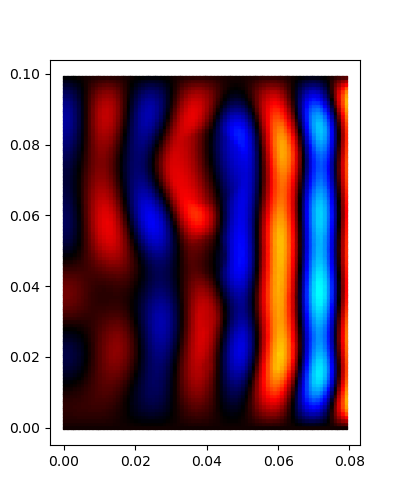

In [129]:
import scipy.interpolate

interp = scipy.interpolate.LinearNDInterpolator(
    points=data.u.field.spatial_points(),
    values=data.u.field.values(),
)

x = data.u.field.spatial_points()
print(x.shape)

u_pred = interp(x)
print(u_pred.shape)

fig, ax = plt.subplots(figsize=(4, 5))
ax.scatter(x[:,0], x[:,1], c=u_pred[:,0].real, s=4, marker='s', **wave_kws)

In [132]:
# interpolate wave field data into FEM function space

def u_true(x):
    print(x[:2].T.shape)
    return interp(x[:2].T).T

u_func = dolfinx.fem.Function(vector_func_space)
u_func.interpolate(u_true)

(46926, 2)


<IPython.core.display.Javascript object>


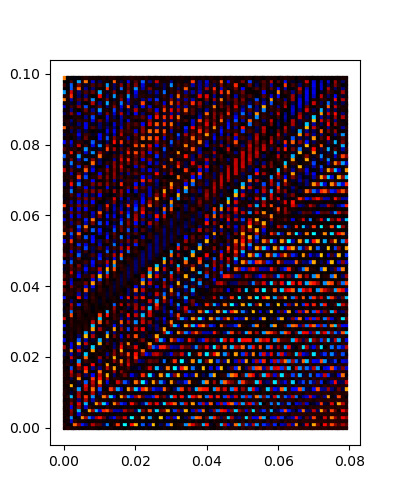

In [136]:
# evaluate wave field function on mesh

x = data.u.field.spatial_points()
x = np.concatenate([x, np.zeros((len(x), 1))], axis=1)

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

u_pred = u_func.eval(x, cells)

fig, ax = plt.subplots(figsize=(4, 5))
ax.scatter(x[:,0], x[:,1], c=u_pred[:,0].real, s=4, marker='s', **wave_kws)

In [222]:
data.u.shape

(1, 80, 100, 2)

<IPython.core.display.Javascript object>


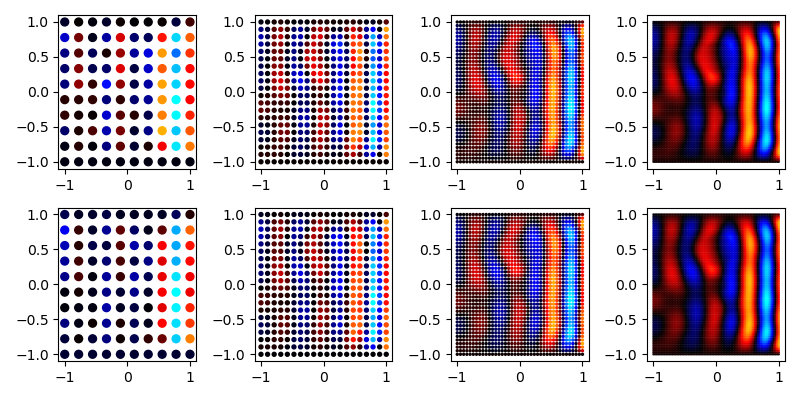

In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import scipy.interpolate

x = np.linspace(-1, 1, 80)
y = np.linspace(-1, 1, 100)
z = np.zeros(1)
xy = np.stack(np.meshgrid(x, y, indexing='ij'), axis=-1).reshape(-1, 2)
xyz = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1).reshape(-1, 3)
values = data.u.values[0,:,:,0].reshape(-1)

interp = scipy.interpolate.LinearNDInterpolator(points=xy, values=values)

fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for i, N in enumerate([10, 20, 40, 80]): # try for different mesh resolutions

    x = np.linspace(-1, 1, N)
    y = np.linspace(-1, 1, N)
    xy = np.stack(np.meshgrid(x, y, indexing='ij'), axis=-1).reshape(-1, 2)
    xyz = np.stack(np.meshgrid(x, y, z, indexing='ij'), axis=-1).reshape(-1, 3)
    interp_values = interp(xy)
    axes[0,i].scatter(*xy.T, c=interp_values, s=3200 / N**2, **wave_kws)
    
    mesh = dolfinx.mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=[[-1, -1], [1, 1]],
        n=[N, N],
        cell_type=dolfinx.mesh.CellType.triangle
    )
    V = dolfinx.fem.FunctionSpace(mesh, ('Lagrange', 1))
    func_pred = dolfinx.fem.Function(V)
    func_pred.interpolate(lambda x: interp(x[:2].T))

    # identify cells that contain the coordinates
    tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
    cells = dolfinx.geometry.compute_collisions(tree, xyz)
    cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, xyz)
    cells = [cells.links(i)[0] for i in range(xyz.shape[0])]

    func_values = func_pred.eval(xyz, cells)
    axes[1,i].scatter(*xy.T, c=func_values, s=3200 / N**2, **wave_kws)

fig.tight_layout()

<IPython.core.display.Javascript object>


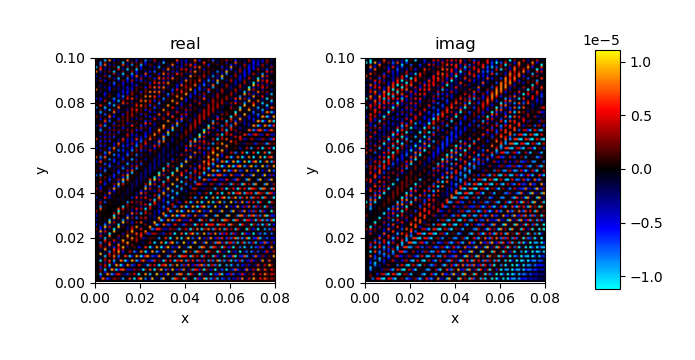

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [17]:
# visualize the interpolated wave field
data['u_pred'] = mre_pinn.utils.as_xarray(u_pred.reshape(*data.u.shape), like=data.u)
wave_kws = mre_pinn.visual.get_color_kws(data.u_pred)
mre_pinn.visual.XArrayViewer(data.u_pred, col='part', ax_width=2, **wave_kws)

<IPython.core.display.Javascript object>


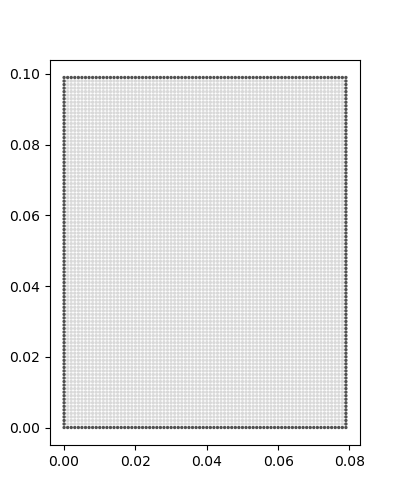

In [42]:
# identify boundary nodes

def on_boundary(x):
    x = x[:2] # assume only 2D
    x_loc = x.mean(axis=1, keepdims=True)
    x_scale = (x.max(axis=1, keepdims=True) - x.min(axis=1, keepdims=True)) / 2
    x = (x - x_loc) / x_scale
    return np.isclose(np.linalg.norm(x, np.inf, axis=0), 1)

y = on_boundary(x.T)
c = y.astype(float) / 2 + 0.25

fig, ax = plt.subplots(figsize=(4, 5))
ax.scatter(*x.T[:2], c=c, s=2, cmap='Greys', vmin=0, vmax=1)

In [ ]:
# setup physical problem and boundary conditions

rho = 1000
omega = 2 * np.pi * 80

mu_func = dolfinx.fem.Function(scalar_func_space)
mu_func.interpolate(lambda x: 3e3 * np.ones_like(x[0]))

boundary_dofs = dolfinx.fem.locate_dofs_geometrical(vector_func_space, on_boundary)
mu_bc = dolfinx.fem.dirichletbc(mu_func, dofs=boundary_dofs)

Variational form:

$$
\begin{align}
    \int_\Omega \mu \nabla u \cdot \nabla \bar{v} d\Omega &= \int_\Omega \rho \omega^2 u \bar{v} d\Omega
\end{align}
$$

In [ ]:
%%time

# solve variational Helmholtz problem
mu_trial_func = ufl.TrialFunction(scalar_func_space)
v_test_func = ufl.TestFunction(vector_func_space)

f_func = dolfinx.fem.Function(scalar_func_space) # source is zero
f_func.interpolate(lambda x: 0 * x[:1])

Ax = mu_trial_func * ufl.inner(ufl.grad(u_func), ufl.grad(v_test_func)) * ufl.dx
b = rho * omega**2 * ufl.inner(u_func, v_test_func) * ufl.dx

problem = dolfinx.fem.petsc.LinearProblem(
    Ax, b, bcs=[mu_bc], petsc_options={"ksp_type": "lsqr", "pc_type": "none"}
)
mu_pred_func = problem.solve()

In [ ]:
# evaluate function on mesh

x = data.u.field.points()[:,1:]
x = np.concatenate([x, np.zeros((len(x), 1))], axis=1) # needs to have z dimension

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

mu_pred = mu_pred_func.eval(x, cells)
mu_pred = mu_pred.reshape(*data.mu.shape)
mu_pred.shape, mu_pred.dtype

In [ ]:
# visualize the elastogram

data['mu_pred'] = mre_pinn.utils.as_xarray(mu_pred, like=data.mu)

elast_kws = mre_pinn.visual.get_color_kws(data.mu_pred)

mre_pinn.visual.XArrayViewer(data.mu_pred, ax_width=2, **elast_kws)